In [1]:
import sys
sys.path.append("/home/yx6674/SpatialMETA")
import spatialmeta as smt
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import copy
import matplotlib.pyplot as plt
import anndata

/home/yx6674/.conda/envs/hm-ot/lib/python3.13/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/yx6674/.conda/envs/hm-ot/lib/python3.13/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/yx6674/.conda/envs/hm-ot/lib/python3.13/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/yx6674/.conda/envs/hm-ot/lib/python3.13/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  return module_get_attr_re

In [2]:
merge_adata = sc.read_h5ad("/scratch/gpfs/BRAPHAEL/ST_SM/joint_STbase_Y7.h5ad")
merge_adata

AnnData object with n_obs × n_vars = 2018 × 37900
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'type', 'name'
    uns: 'features', 'joint_base', 'spatial'
    obsm: 'coupling_to_SM', 'spatial'

In [3]:
merge_adata.layers["counts"] = merge_adata.X.copy()
smt.pp.normalize_total_joint_adata_sm_st(merge_adata,
                         target_sum_SM=1e4,
                         target_sum_ST=1e4)
merge_adata.layers["normalized"] = merge_adata.X.copy()

In [4]:
smt.pp.spatial_variable_joint_adata_sm_st(
    merge_adata,
    n_top_genes = 2500,
    n_top_metabolites = 1000,
    #batch_key="sample",
    min_samples = 3,
    min_frac = 0.9,
    min_logfc= 3,
)

In [5]:
merge_adata = merge_adata[:,merge_adata.var.highly_variable_moranI]
merge_adata

View of AnnData object with n_obs × n_vars = 2018 × 3500
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'type', 'name', 'highly_variable_moranI'
    uns: 'features', 'joint_base', 'spatial'
    obsm: 'coupling_to_SM', 'spatial'
    layers: 'counts', 'normalized'

In [6]:
model = smt.model.ConditionalVAESTSM(
    merge_adata,
    n_latent=10,
    device='cuda:0',
    #batch_keys= ["sample"],
    #batch_embedding="embedding",
    reconstruction_method_sm='g',
    reconstruction_method_st='zinb',
)

In [7]:
loss_dict = model.fit(
    max_epoch=64, 
    lr=1e-3,
    kl_loss_reduction= 'mean',
    mode='multi'
)

Epoch 64: 100%|██████████| 64/64 [00:21<00:00,  2.94it/s, reconst_sm=2.66e+02, reconst_st=4.34e+02, reconst_sm_corr=2.24e+02, reconst_st_corr=4.33e+02, kldiv=3.68e+00, total_loss=7.92e+03, mmd_loss=0.00e+00]


In [20]:
loss_dict

{'epoch_reconstruction_loss_st_list': [601.4947929382324,
  515.644157409668,
  486.671932220459,
  473.54856300354004,
  464.53026962280273,
  459.3924388885498,
  456.0676860809326,
  453.6101760864258,
  450.7919292449951,
  449.140323638916,
  447.8592109680176,
  446.09145164489746,
  445.2031497955322,
  444.41052055358887,
  443.69448471069336,
  443.1467990875244,
  442.05890464782715,
  441.56126403808594,
  441.1199607849121,
  440.55619621276855,
  439.9691410064697,
  439.7974510192871,
  439.42756843566895,
  439.2636241912842,
  439.02794075012207,
  438.35577392578125,
  438.5461120605469,
  438.87763595581055,
  437.9797611236572,
  437.4699935913086,
  438.00288009643555,
  437.5507526397705,
  437.32960510253906,
  437.3600902557373,
  437.2134647369385,
  436.8836212158203,
  436.7809257507324,
  436.5625591278076,
  436.55762481689453,
  436.98707389831543,
  436.964879989624,
  436.26606941223145,
  436.05919456481934,
  436.26736640930176,
  435.88160514831543,
  

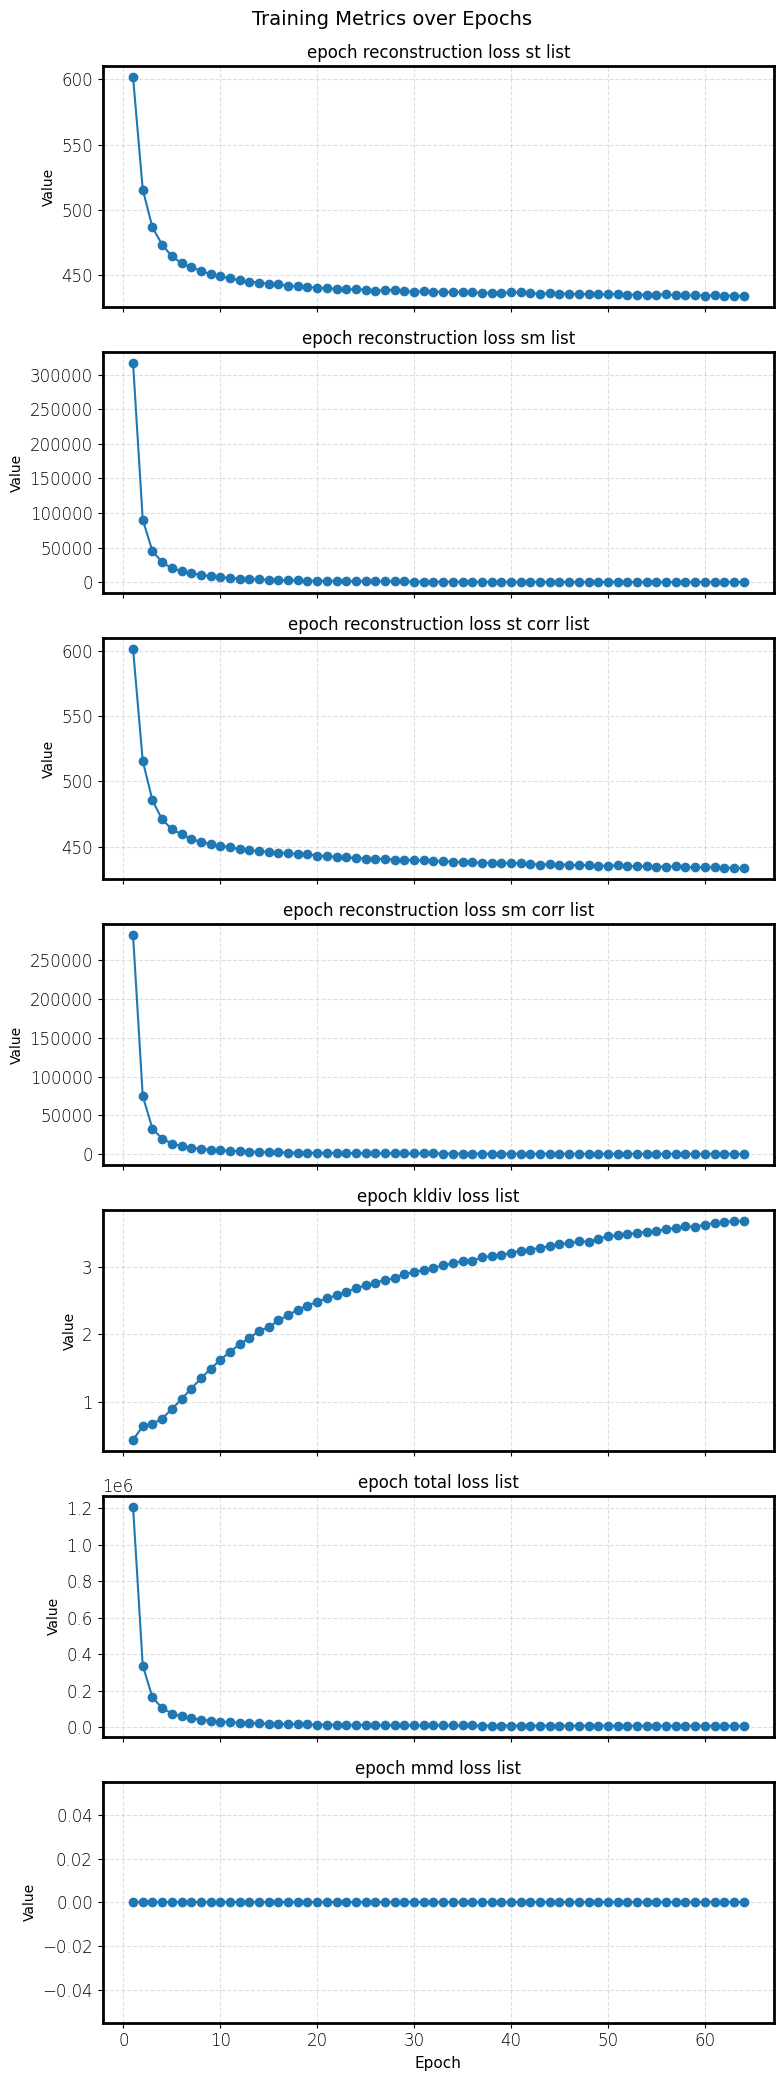

In [8]:
n_keys = len(loss_dict)
plt.rcParams['font.family'] = 'DejaVu Sans'

fig, axes = plt.subplots(n_keys, 1, figsize=(8, 3 * n_keys), sharex=True)

# Make sure axes is iterable even if only one key
if n_keys == 1:
    axes = [axes]

# Plot each key
for ax, (key, values) in zip(axes, loss_dict.items()):
    epochs = list(range(1, len(values) + 1))
    ax.plot(epochs, values, marker='o', linewidth=1.5)
    ax.set_title(key.replace("_", " "), fontsize=12)
    ax.set_ylabel("Value", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.4)

axes[-1].set_xlabel("Epoch", fontsize=11)
fig.suptitle("Training Metrics over Epochs", fontsize=14, y=0.99)
plt.tight_layout()
plt.show()

In [9]:
Z = model.get_latent_embedding()
X = model.get_normalized_expression()
C = model.get_modality_contribution()

Latent Embedding: 100%|██████████| 16/16 [04:16<00:00, 16.02s/it]


In [10]:
merge_adata.layers['reconstruction'] = X
merge_adata.obsm['X_emb']=Z
merge_adata.obsm['contribution_st']=Z
merge_adata.obsm['contribution_sm']=1-Z

In [11]:
sc.pp.neighbors(merge_adata,
                use_rep="X_emb",
                n_neighbors=20)

In [12]:
sc.tl.umap(merge_adata,
           min_dist=1,
           spread=1)

In [13]:
sc.tl.leiden(merge_adata, 
             resolution= 1,
             key_added="VAE_clusters_latent10")

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

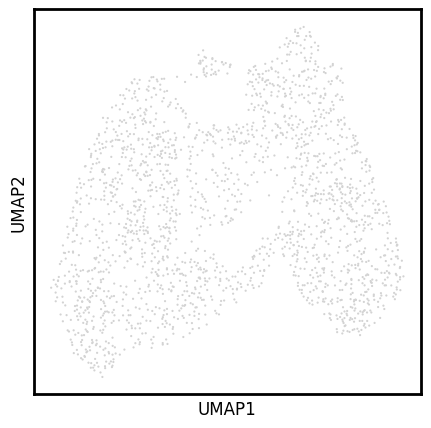

In [16]:
fig,ax=plt.subplots()
fig.set_size_inches(5,5)
sc.pl.umap(merge_adata,
           #color=["sample"],
           #palette = {
              # "R114_T": "#F97300",
              # "S15_T": "#7469B6",
              # "X49_T": "#7ABA78",
              # "Y27_T": "#03AED2",
              # "Y7_T": "#F3CA52",
           #},
           show = False,
           size = 10,
           ax=ax
)

<Axes: title={'center': 'VAE_clusters_latent10'}, xlabel='UMAP1', ylabel='UMAP2'>

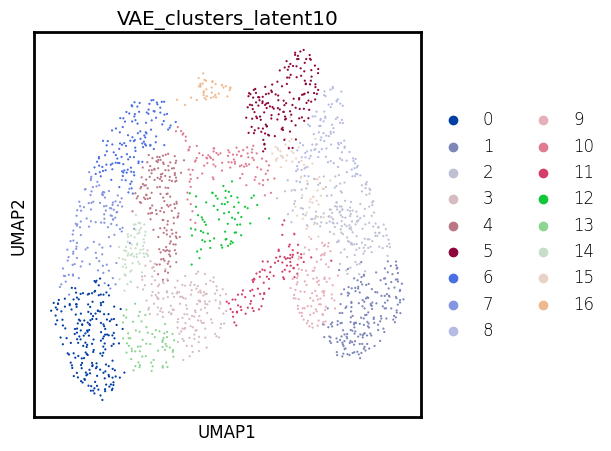

In [17]:
fig,ax=plt.subplots()
fig.set_size_inches(5,5)
sc.pl.umap(merge_adata,
           color=["VAE_clusters_latent10"],
           palette = sc.pl.palettes.default_28,
           show = False,
           size = 10,
           ax=ax
)

In [18]:
merge_adata

AnnData object with n_obs × n_vars = 2018 × 3500
    obs: 'in_tissue', 'array_row', 'array_col', 'VAE_clusters_latent10'
    var: 'gene_ids', 'feature_types', 'genome', 'type', 'name', 'highly_variable_moranI'
    uns: 'features', 'joint_base', 'spatial', 'neighbors', 'umap', 'VAE_clusters_latent10', 'VAE_clusters_latent10_colors'
    obsm: 'coupling_to_SM', 'spatial', 'X_emb', 'contribution_st', 'contribution_sm', 'X_umap'
    layers: 'counts', 'normalized', 'reconstruction'
    obsp: 'distances', 'connectivities'

In [19]:
merge_adata.write_h5ad("/scratch/gpfs/BRAPHAEL/ST_SM/Y7_joint_ManifoldGW.h5ad")

In [1]:
import sys
import scanpy as sc
sys.path.append("/home/yx6674/SpatialMETA")
from benchmark.multi_benmark_function import run_modality_benchmark, run_all_modality_adata

/home/yx6674/.conda/envs/hm-ot/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/yx6674/.conda/envs/hm-ot/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:532: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left = partial(_left_join_spatialelement_table)
/home/yx6674/.conda/envs/hm-ot/lib/python3.13/site-packages/spatialdata/_core/query/relational_query.py:533: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  left_exclusive = partial(_left_exclusive_join_spatialel

In [2]:
try:
    import IPython.display as _ipd
    # Only patch if missing
    if not hasattr(_ipd, "set_matplotlib_formats"):
        from matplotlib_inline.backend_inline import set_matplotlib_formats as _set_mpl_formats
        _ipd.set_matplotlib_formats = _set_mpl_formats
except Exception as e:
    print("Warning: could not patch set_matplotlib_formats:", e)

In [11]:
from pathlib import Path
import pandas as pd
merge_adata = sc.read_h5ad("/scratch/gpfs/BRAPHAEL/ST_SM/Y7_joint_ManifoldGW.h5ad")
merge_adata.obsm["multi_emb"] = merge_adata.obsm["X_emb"]
assert "multi_emb" in merge_adata.obsm       
assert "spatial" in merge_adata.obsm            
assert "type" in merge_adata.var.columns       
assert "counts" in merge_adata.layers          

# --- choose your embedding key ---
emb_key = "multi_emb" if "multi_emb" in merge_adata.obsm else "X_emb"
assert emb_key in merge_adata.obsm, "No embedding found in .obsm['multi_emb'] or .obsm['X_emb']"

# --- build graph on the embedding and run Leiden ---
sc.pp.neighbors(merge_adata, use_rep=emb_key, n_neighbors=15, metric="euclidean")
sc.tl.leiden(merge_adata, resolution=1.0, key_added="leiden_cluster")

# --- save parquet in the expected format & path ---
embedding_dir = Path("./my_embedding_dir")
embedding_dir.mkdir(exist_ok=True)

df = pd.DataFrame({
    "barcode": merge_adata.obs_names.astype(str),
    "leiden_cluster": merge_adata.obs["leiden_cluster"].astype(str)
})
df.to_parquet(embedding_dir / "leiden_clusters_1.parquet", index=False)

print("Wrote:", embedding_dir / "leiden_clusters_1.parquet")

results = run_modality_benchmark(merge_adata, embedding_dir)
print(results)

2025-10-18 20:21:56,885 - INFO - Seed set to 2024


Wrote: my_embedding_dir/leiden_clusters_1.parquet


2025-10-18 20:21:58,510 - INFO - run_multi_benchmark: Found 2018 common barcodes for mapping Leiden clusters.
2025-10-18 20:21:58,513 - INFO - run_multi_benchmark: Successfully mapped Leiden clusters. Unique Leiden clusters: ['3', '15', '5', '4', '9', '7', '13', '14', '0', '1', '18', '8', '2', '16', '6', '10', '11', '17', '12']
2025-10-18 20:21:58,514 - INFO - Leiden cluster counts: {'0': 209, '1': 204, '2': 168, '3': 154, '4': 140, '5': 133, '6': 122, '7': 100, '8': 97, '10': 92, '9': 92, '11': 86, '12': 75, '13': 71, '14': 68, '15': 63, '16': 56, '17': 50, '18': 38}
2025-10-18 20:21:58,515 - WARNING - run_multi_benchmark: Ground truth key 'pathological_annotation' not found. Skipping ground truth metrics.
  0%|          | 0/100 [00:00<?, ?/s]/home/yx6674/.conda/envs/hm-ot/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.quer

{'leiden_clusters': 19, 'ARI': nan, 'NMI': nan, 'isolated_asw': nan, 'clisi_graph': nan, 'gt_silhouette': nan, 'CHAOS': 0.08496575035008656, 'PAS': 0.32755203171456887, 'ASW': -0.03021903673974271, 'ST_moranI_top5': 0.4758571171050487, 'ST_gearyC_top5': 0.5216623765579999, 'ST_moranI_top10': 0.33096887527645097, 'ST_gearyC_top10': 0.6652022159754564, 'ST_moranI_top20': 0.24912080235811268, 'ST_gearyC_top20': 0.7485565587254266, 'ST_moranI_top50': 0.15422645610671737, 'ST_gearyC_top50': 0.8405721725637204, 'ST_moranI_top100': 0.1013965960195216, 'ST_gearyC_top100': 0.895477976034056, 'ST_moranI_top200': 0.05940996335994607, 'ST_gearyC_top200': 0.9373047038787321, 'ST_moranI_top500': 0.044745278218330214, 'ST_gearyC_top500': 0.9530722890285995, 'SM_moranI_top5': 0.9077710610203238, 'SM_gearyC_top5': 0.08244717663459206, 'SM_moranI_top10': 0.9072696530193332, 'SM_gearyC_top10': 0.08308054335894208, 'SM_moranI_top20': 0.9073007765220431, 'SM_gearyC_top20': 0.08415722043215838, 'SM_moranI_t

In [12]:
results

{'leiden_clusters': 19,
 'ARI': nan,
 'NMI': nan,
 'isolated_asw': nan,
 'clisi_graph': nan,
 'gt_silhouette': nan,
 'CHAOS': 0.08496575035008656,
 'PAS': 0.32755203171456887,
 'ASW': -0.03021903673974271,
 'ST_moranI_top5': 0.4758571171050487,
 'ST_gearyC_top5': 0.5216623765579999,
 'ST_moranI_top10': 0.33096887527645097,
 'ST_gearyC_top10': 0.6652022159754564,
 'ST_moranI_top20': 0.24912080235811268,
 'ST_gearyC_top20': 0.7485565587254266,
 'ST_moranI_top50': 0.15422645610671737,
 'ST_gearyC_top50': 0.8405721725637204,
 'ST_moranI_top100': 0.1013965960195216,
 'ST_gearyC_top100': 0.895477976034056,
 'ST_moranI_top200': 0.05940996335994607,
 'ST_gearyC_top200': 0.9373047038787321,
 'ST_moranI_top500': 0.044745278218330214,
 'ST_gearyC_top500': 0.9530722890285995,
 'SM_moranI_top5': 0.9077710610203238,
 'SM_gearyC_top5': 0.08244717663459206,
 'SM_moranI_top10': 0.9072696530193332,
 'SM_gearyC_top10': 0.08308054335894208,
 'SM_moranI_top20': 0.9073007765220431,
 'SM_gearyC_top20': 0.084

In [6]:
import scanpy as sc

In [8]:
adata2 = sc.read_h5ad("/scratch/gpfs/BRAPHAEL/ST_SM/Y7_T_adata_joint_hvf2800_spatialmeta.h5ad")
adata2

AnnData object with n_obs × n_vars = 1956 × 2800
    obs: 'x_coord', 'y_coord', 'spot_name', 'total_intensity', 'mean_intensity', 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'contribution_st-sm', 'cor_sm', 'cor_st', 'VAE_clusters_latent10', 'contribution_st', 'contribution_sm'
    var: 'name', 'type', 'highly_variable_moranI'
    uns: 'VAE_clusters_latent10', 'VAE_clusters_latent10_colors', 'neighbors', 'spatial', 'umap'
    obsm: 'X_emb', 'X_emb_sm', 'X_emb_st', 'X_umap', 'spatial'
    layers: 'counts', 'normalized', 'reconstruction', 'reconstruction_corr', 'reconstruction_dropout', 'reconstruction_dropout_corr', 'reconstruction_rate', 'reconstruction_rate_corr'
    obsp: 'connectivities', 'distances'

In [3]:
import sys
import scanpy as sc
sys.path.append("/home/yx6674/SpatialMETA")
from benchmark.multi_benmark_function import run_modality_benchmark, run_all_modality_adata
from pathlib import Path
import pandas as pd
merge_adata = sc.read_h5ad("/scratch/gpfs/BRAPHAEL/ST_SM/ccRCC_merge_spatialmeta.h5ad")
merge_adata.obs_names_make_unique()
merge_adata.obsm["multi_emb"] = merge_adata.obsm["X_emb"]
assert "multi_emb" in merge_adata.obsm       
assert "spatial" in merge_adata.obsm            
assert "type" in merge_adata.var.columns       
assert "counts" in merge_adata.layers          

# --- choose your embedding key ---
emb_key = "multi_emb" if "multi_emb" in merge_adata.obsm else "X_emb"
assert emb_key in merge_adata.obsm, "No embedding found in .obsm['multi_emb'] or .obsm['X_emb']"


# --- save parquet in the expected format & path ---
embedding_dir = Path("./other_embedding_dir")

results = run_modality_benchmark(merge_adata, embedding_dir)
print(results)

2025-10-18 20:59:48,099 - INFO - Seed set to 2024
2025-10-18 20:59:48,190 - INFO - run_multi_benchmark: Found 13002 common barcodes for mapping Leiden clusters.
2025-10-18 20:59:48,200 - INFO - run_multi_benchmark: Successfully mapped Leiden clusters. Unique Leiden clusters: ['7', '3', '4', '23', '22', '0', '21', '6', '8', '10', '16', '1', '19', '14', '5', '9', '2', '11', '18', '20', '12', '13', '15', '17']
2025-10-18 20:59:48,202 - INFO - Leiden cluster counts: {'0': 1156, '1': 1127, '2': 959, '3': 923, '4': 899, '5': 894, '6': 646, '7': 640, '8': 602, '9': 600, '10': 562, '11': 516, '12': 492, '13': 488, '14': 382, '15': 368, '16': 357, '17': 357, '18': 260, '19': 218, '20': 196, '21': 165, '22': 126, '23': 69}
2025-10-18 20:59:48,203 - WARNING - run_multi_benchmark: Ground truth key 'pathological_annotation' not found. Skipping ground truth metrics.
  0%|          | 0/100 [00:00<?, ?/s]/home/yx6674/.conda/envs/hm-ot/lib/python3.13/site-packages/dask/dataframe/__init__.py:31: FutureW

KeyboardInterrupt: 